(Notebook modified from https://course.ccs.neu.edu/ds4440f20/)

**Instructions:** Answer the four questions below in the notebook itself. Submit your notebook on Canvas and a pdf printout.


### Convolutional Neural Networks

A simple example to demonstrate the ideas introduced in lecture and (relatively)
 simple exercises

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import transforms

In [2]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Q1. Write code to answer the questiosn below:**
- How many images are there in `train_data` and `test_data`?
- How many labels are there in `train_data`?
- What is the height and width of each image?

The answer to Q1 is the code that outputs the answers to the questions above.

In [8]:
## YOUR CODE GOES HERE

print("There are "+ str(len(train_set)) + " images in train_data and " + str(len(test_set)) + " images in test_data ")
print("There are "+str(len(train_set.classes)) +" labels in train_data ")
print("The height, weight of each image is "+str(list(train_set.__getitem__(0)[0].size())[1:]) +" respectively")

There are 60000 images in train_data and 10000 images in test_data 
There are 10 labels in train_data 
The height, weight of each image is [28, 28] respectively


In [10]:
# Note: the `out_channels` argument is what we referred to as the number of
# filters in lecture. 
conv_layer = nn.Conv2d(in_channels=1, out_channels=5, stride=2, kernel_size=3)

In [11]:
conv_layer.weight.shape

torch.Size([5, 1, 3, 3])

In [13]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size, 
                                          shuffle=False)

**Q2. Answer the following questions (no code required):**

- What is the meaning of `shuffle=True` and `shuffle=False`
- Why do we shuffle the train data?
- Why don't we shuffle the test data?

The answer to Q2 is a few sentences, no code required.

Ans
  
  1) If we give shuffle as true then data will be shuffled and if it is false then input data will not be shuffled.
  
  2) The order we give as input might effect the the neural network learning. So we will shuffle the data will sending input so that different labels can be send in different sequence.

3)As Testing dataset not involved in training Neural network, there is no need to shuffle the data.


### Full example

Derived from: [https://github.com/yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial).

In [14]:
device = 'cuda'
num_epochs = 5
num_classes = 10
learning_rate = 0.001

# A simple convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

with torch.no_grad():
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels)
        all_preds.extend(predicted)
    ##
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/5], Step [100/1875], Loss: 0.6698
Epoch [1/5], Step [200/1875], Loss: 0.4632
Epoch [1/5], Step [300/1875], Loss: 0.6196
Epoch [1/5], Step [400/1875], Loss: 0.2420
Epoch [1/5], Step [500/1875], Loss: 0.3209
Epoch [1/5], Step [600/1875], Loss: 0.4419
Epoch [1/5], Step [700/1875], Loss: 0.4335
Epoch [1/5], Step [800/1875], Loss: 0.2492
Epoch [1/5], Step [900/1875], Loss: 0.1966
Epoch [1/5], Step [1000/1875], Loss: 0.6796
Epoch [1/5], Step [1100/1875], Loss: 0.1027
Epoch [1/5], Step [1200/1875], Loss: 0.3895
Epoch [1/5], Step [1300/1875], Loss: 0.3993
Epoch [1/5], Step [1400/1875], Loss: 0.3690
Epoch [1/5], Step [1500/1875], Loss: 0.2215
Epoch [1/5], Step [1600/1875], Loss: 0.2232
Epoch [1/5], Step [1700/1875], Loss: 0.2372
Epoch [1/5], Step [1800/1875], Loss: 0.0884
Epoch [2/5], Step [100/1875], Loss: 0.4224
Epoch [2/5], Step [200/1875], Loss: 0.1256
Epoch [2/5], Step [300/1875], Loss: 0.3107
Epoch [2/5], Step [400/1875], Loss: 0.3697
Epoch [2/5], Step [500/1875], Loss: 0.3340
Ep

**Q3. Answer the following question:** 

The implementation above uses Batch Normalization (`nn.BatchNorm2d(16)`)

- Explain Batch Normalization with your own words. Get inspiration from here: https://d2l.ai/chapter_convolutional-modern/batch-norm.html (or any other source, but use your own words and an example)

The answer to Q3 does not require any code, a good answer will have an intu explanation and an example (toy example is fine).

ANS 

For deep neural networks with large number of hidden layers, the inputs for layers deep in the network has very large magnitudes and magnitude only increases with the increase in the depth of the layer.

In batch normalization we normalize the out put from the previous layer and feed it forward to the next layer inorder to converge the large networks and magnitudes.


**Q4. Answer the questions below:**

You will do a qualitative analysis beyond stating that the accuracy in the test set is `90.27%`.

- Which labels are harder to get right? You will have to print the accuracy per label (sorted from low to high)
- Generate a confusion matrix for the output of your model. A confusion matrix looks like the one here (toward the bottom): https://www.kaggle.com/fuzzywizard/fashion-mnist-cnn-keras-accuracy-93
- Interpret the numbers you see in the confusion matrix. Does it make sense (intuitively, no proof required) that certain classes are more often confused?

The answer to Q4 requires you to write some code and interpret the output of yout code. A good answer will have 2-3 paragraphs. You are expected to interpret the numbers, not just state the numbers in the confusion matrix.

In [38]:
import matplotlib as mp
import matplotlib.pyplot as plot
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msn
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(confmatrx,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(confmatrx) / np.sum(confmatrx).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(15, 10))
    plt.imshow(confmatrx, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        confmatrx = confmatrx.astype('float') / confmatrx.sum(axis=1)[:, np.newaxis]


    thresh = confmatrx.max() / 1.5 if normalize else confmatrx.max() / 2
    for i, j in itertools.product(range(confmatrx.shape[0]), range(confmatrx.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(confmatrx[i, j]),
                     horizontalalignment="center",
                     color="white" if confmatrx[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(confmatrx[i, j]),
                     horizontalalignment="center",
                     color="white" if confmatrx[i, j] > thresh else "black")


    plot.tight_layout()
    plot.ylabel('True label')
    plot.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plot.show()


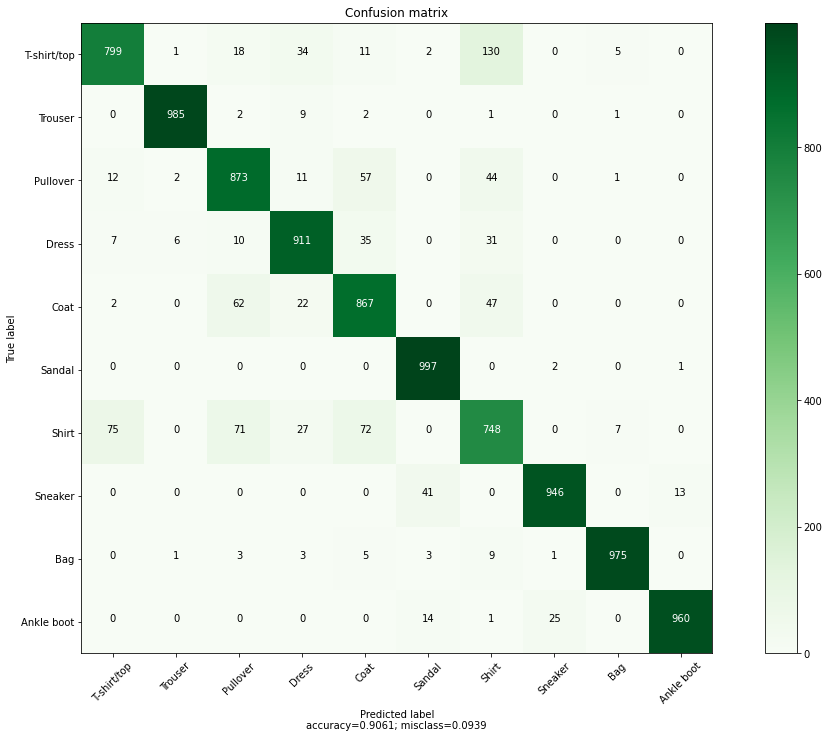

In [39]:
all_labels_list=[i.item() for i in all_labels]
all_preds_list=[i.item() for i in all_preds]
plot_confusion_matrix(confmatrx=confusion_matrix(y_true=all_labels_list, y_pred=all_preds_list), target_names=train_set.classes, normalize=False)

In [42]:
class_count_true=[0]*len(train_set.classes)
class_count_prediction=[0]*len(train_set.classes)
for a,b in zip(all_labels_list,all_preds_list):
  class_count_true[a]+=1
  if a==b:
    class_count_prediction[a]+=1
class_pred={}
for i in range(len(class_count_prediction)):
  class_pred[train_set.classes[i]]=(class_count_prediction[i]/class_count_true[i])*100
for i in sorted(class_pred.items(), key=lambda item: item[1]):
  print(f"Accuracy of {i[0]} : {i[1]}")

Accuracy of Shirt : 74.8
Accuracy of T-shirt/top : 79.9
Accuracy of Coat : 86.7
Accuracy of Pullover : 87.3
Accuracy of Dress : 91.10000000000001
Accuracy of Sneaker : 94.6
Accuracy of Ankle boot : 96.0
Accuracy of Bag : 97.5
Accuracy of Trouser : 98.5
Accuracy of Sandal : 99.7


True positivity of Shirt is very less compared to other classes becuase the ground value of Shirt are being predicted as T-shirt.

It can also be seen that sandal is also being confused with Sneaker a few times.